In [141]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4
# import nc_time_axis
import matplotlib.pyplot as plt
import glob
import cmocean
import xskillscore as xs
import datetime
# from sklearn.metrics import mean_squared_error

import h5py
from scipy.io import loadmat
from scipy import signal
from scipy.interpolate import griddata
import cartopy.crs as ccrs

from scipy.optimize import curve_fit
from scipy.stats import linregress

In [2]:
## Working directory
wrk_dir = '~/work/OBS/dashcams_data/plotting_for_draft_supplementary/'

# read the RBR data

In [3]:
rbr_ds = pd.read_csv(wrk_dir + '065816_20201102_1417_01.csv',header=15)

In [4]:
rbr_ds.columns = rbr_ds.columns.str.strip()

rbr_ds

,//Time(yyyy-mm-dd HH:MM:ss.FFF),Temperature(°C),Pressure(dbar),Sea_Pressure(dbar)
0,2020-11-02 14:17:43.333,16.9499,10.0850,-0.0475
1,2020-11-02 14:17:43.417,16.9386,10.0852,-0.0473
2,2020-11-02 14:17:43.500,16.9130,10.0870,-0.0455
3,2020-11-02 14:17:43.583,16.9061,10.0845,-0.0480
4,2020-11-02 14:17:43.667,16.8979,10.0844,-0.0481
...,...,...,...,...
95241,2020-11-02 16:30:00.083,11.4476,10.0980,-0.0345
95242,2020-11-02 16:30:00.167,11.4467,10.0974,-0.0351
95243,2020-11-02 16:30:00.250,11.4458,10.0981,-0.0344
95244,2020-11-02 16:30:00.333,11.4449,10.0974,-0.0351


Text(0.5, 1.0, 'Temperature over Time')

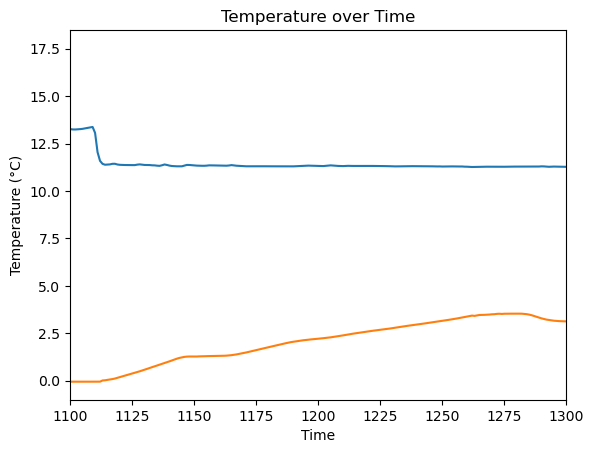

In [5]:
rbr_ds['Temperature(°C)'].plot()
rbr_ds['Sea_Pressure(dbar)'].plot()
# rbr_ds.plot(x='//Time(yyyy-mm-dd HH:MM:ss.FFF)', y='Sea_Pressure(dbar)')

plt.xlim(1100, 1300)
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Temperature over Time')
# plt.show()

In [6]:
index_change = np.where(np.diff(np.sign(rbr_ds['Sea_Pressure(dbar)'])))[0]
index_change_start = np.where(np.diff(np.sign(rbr_ds['Sea_Pressure(dbar)'])) > 0)[0]
index_change_end = np.where(np.diff(np.sign(rbr_ds['Sea_Pressure(dbar)'])) < 0)[0]
index_change_start


array([ 1112,  2899,  4332,  5768,  7583,  9296,  9304,  9316,  9324,
        9353, 19791, 21275, 22674, 24127, 25919, 35990, 37463, 38886,
       40308, 42157, 60877, 62638, 64082, 65528, 67008, 68773, 83164,
       84638, 86095, 87492, 89275])

In [7]:
index_change_end

array([ 1879,  3590,  5003,  6782,  9291,  9301,  9305,  9317,  9325,
        9354, 20473, 21950, 23388, 25163, 27316, 36661, 38146, 39588,
       41358, 43537, 61610, 63410, 64854, 66312, 68086, 70446, 83834,
       85287, 86716, 88563, 90616])

1112 1879


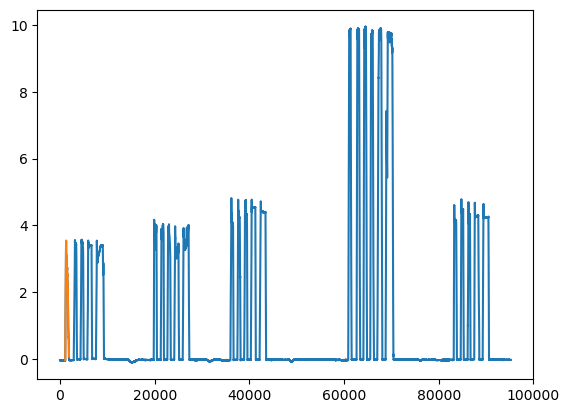

In [8]:
rbr_ds['Sea_Pressure(dbar)'].plot()

for istart, iend in zip(index_change_start, index_change_end):
    print(istart, iend)
    rbr_ds['Sea_Pressure(dbar)'][istart:iend].plot()
    break
    # plt.xlim(istart-30, iend+30)
# rbr_ds['Sea_Pressure(dbar)'][index_change_start[0]:index_change_end[0]].plot()

# plt.xlim(index_change_start[0]-30, index_change_end[0]+30)

## create rbr data to xarray

In [17]:
rbr_xr = xr.Dataset.from_dataframe(rbr_ds)

rbr_xr = xr.Dataset(
    {
        'Temperature(°C)': ('time', rbr_ds['Temperature(°C)']),
        'Pressure(dbar)': ('time', rbr_ds['Pressure(dbar)']),
        'Sea_Pressure(dbar)': ('time', rbr_ds['Sea_Pressure(dbar)'])
    },
    coords={
        'time': pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'])
    }
)
rbr_xr

<xarray.Dataset>
Dimensions:             (time: 95246)
Coordinates:
  * time                (time) datetime64[ns] 2020-11-02T14:17:43.333000 ... ...
Data variables:
    Temperature(°C)     (time) float64 16.95 16.94 16.91 ... 11.45 11.44 11.44
    Pressure(dbar)      (time) float64 10.09 10.09 10.09 ... 10.1 10.1 10.1
    Sea_Pressure(dbar)  (time) float64 -0.0475 -0.0473 ... -0.0351 -0.0361

# Read Tag data

In [10]:
tag_ds = pd.read_csv('/home/server/pi/homes/liux8/work/mnt/RBR_CTD_Casts/Ornitela_Yaquina_2020_11/Ornitela_casts/203018_20201104_000000.csv')
tag_ds = tag_ds.to_xarray()
tag_ds['PST_datetime'] = tag_ds.UTC_datetime.astype('datetime64[ns]') - np.timedelta64(8, 'h')


In [125]:
# Initialize the mask variable in tag_ds
tag_ds['mask'] = xr.DataArray(np.zeros(tag_ds['UTC_datetime'].shape, dtype=bool), dims=tag_ds['UTC_datetime'].dims)

iprofile=1
for istart, iend in zip(index_change_start, index_change_end):
    start_time = pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'][istart])
    end_time = pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'][iend])
    print(start_time, end_time)
    # break
    imask = (pd.to_datetime(tag_ds['PST_datetime']) >= start_time) & (pd.to_datetime(tag_ds['PST_datetime']) <= end_time)
    tag_ds['mask'] = xr.where(imask, iprofile, tag_ds['mask'])
    # tag_ds['mask'] = xr.where(mask, True, tag_ds['mask'])
    iprofile+=1


2020-11-02 14:19:16 2020-11-02 14:20:19.917000
2020-11-02 14:21:44.917000 2020-11-02 14:22:42.500000
2020-11-02 14:23:44.333000 2020-11-02 14:24:40.250000
2020-11-02 14:25:44 2020-11-02 14:27:08.500000
2020-11-02 14:28:15.250000 2020-11-02 14:30:37.583000
2020-11-02 14:30:38 2020-11-02 14:30:38.417000
2020-11-02 14:30:38.667000 2020-11-02 14:30:38.750000
2020-11-02 14:30:39.667000 2020-11-02 14:30:39.750000
2020-11-02 14:30:40.333000 2020-11-02 14:30:40.417000
2020-11-02 14:30:42.750000 2020-11-02 14:30:42.833000
2020-11-02 14:45:12.583000 2020-11-02 14:46:09.417000
2020-11-02 14:47:16.250000 2020-11-02 14:48:12.500000
2020-11-02 14:49:12.833000 2020-11-02 14:50:12.333000
2020-11-02 14:51:13.917000 2020-11-02 14:52:40.250000
2020-11-02 14:53:43.250000 2020-11-02 14:55:39.667000
2020-11-02 15:07:42.500000 2020-11-02 15:08:38.417000
2020-11-02 15:09:45.250000 2020-11-02 15:10:42.167000
2020-11-02 15:11:43.833000 2020-11-02 15:12:42.333000
2020-11-02 15:13:42.333000 2020-11-02 15:15:09.83

In [126]:
np.unique(tag_ds.mask)

array([ 0,  1,  2,  3,  4,  5, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31])

In [127]:
tag_ds_dives=tag_ds.where(~np.isnan(tag_ds.depth_m),drop=True)

In [128]:
np.unique(tag_ds_dives.mask)

array([ 0.,  1.,  2.,  3.,  4.,  5., 11., 12., 13., 14., 15., 16., 19.,
       20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31.])

Text(0, 0.5, 'Temperature (C)')

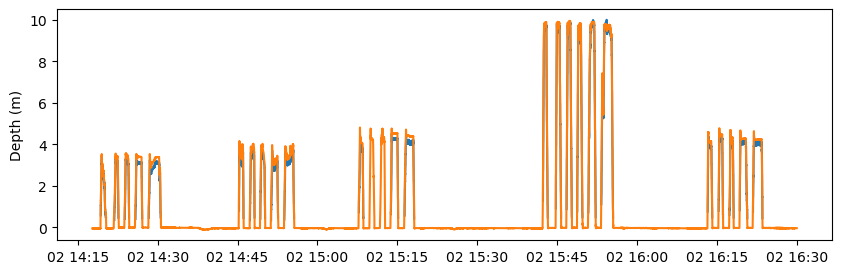

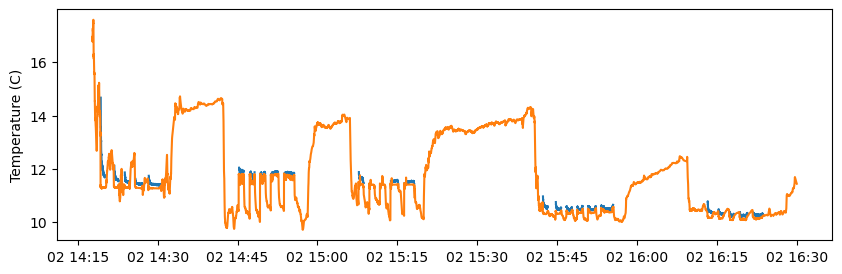

In [188]:
plt.figure(figsize=(10, 3))
plt.plot(tag_ds['PST_datetime'],tag_ds['depth_m'])
# plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'])

plt.plot(pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)']),rbr_ds['Sea_Pressure(dbar)'])
plt.ylabel('Depth (m)')

plt.figure(figsize=(10, 3))
plt.plot(tag_ds['PST_datetime'],tag_ds['ext_temperature_C'])

# plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'])

plt.plot(pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)']),rbr_ds['Temperature(°C)'])
# plt.xlim(start_time, end_time)
plt.ylabel('Temperature (C)')

# interpolate rbr data to the Tag grid points

## interpolate the first time

In [130]:
# # Interpolate rbr_xr to tag_ds['PST_datetime']
interpolated_rbr = rbr_xr.interp(time=tag_ds_dives['PST_datetime'].values)

interpolated_rbr

<xarray.Dataset>
Dimensions:             (time: 17471)
Coordinates:
  * time                (time) datetime64[ns] 2020-11-02T14:19:19 ... 2020-11...
Data variables:
    Temperature(°C)     (time) float64 11.37 11.37 11.37 ... 10.23 10.23 10.23
    Pressure(dbar)      (time) float64 11.41 11.41 11.41 ... 10.58 10.58 10.58
    Sea_Pressure(dbar)  (time) float64 1.279 1.279 1.279 ... 0.4484 0.4484

(18568.596701388888, 18568.597569444446)

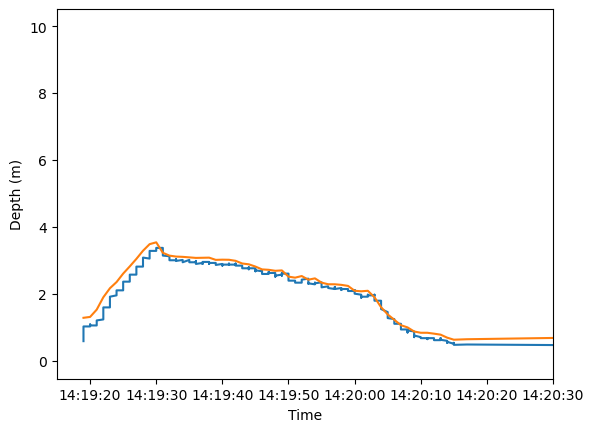

In [182]:
plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'])
plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'])
# plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'])
plt.xlabel('Time')
plt.ylabel('Depth (m)')
plt.xlim(pd.to_datetime('2020-11-02 14:19:15'), pd.to_datetime('2020-11-02 14:20:30'))

(18568.596701388888, 18568.597569444446)

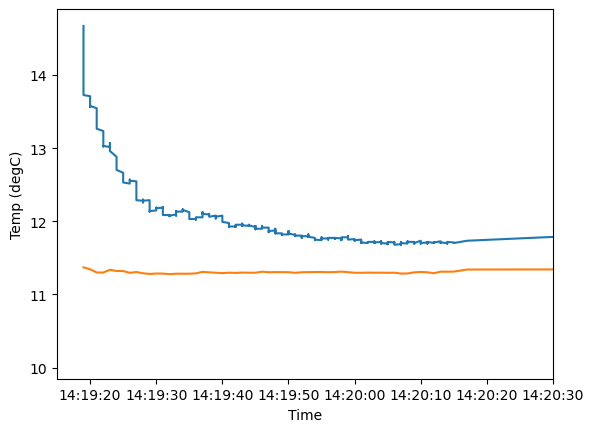

In [184]:
plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['ext_temperature_C'])
plt.plot(interpolated_rbr['time'],interpolated_rbr['Temperature(°C)'])
# plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'])
plt.xlabel('Time')
plt.ylabel('Temp (degC)')
plt.xlim(pd.to_datetime('2020-11-02 14:19:15'), pd.to_datetime('2020-11-02 14:20:30'))

## calculate the lag by corvaince

In [26]:
from scipy.signal import correlate

def xcovar(x, y, maxlags):
    N = len(x)
    x = x - np.mean(x)
    y = y - np.mean(y)
    Rxy = correlate(x, y, mode='full', method='auto') / N
    lags = np.arange(-maxlags, maxlags + 1)
    Rxy = Rxy[N - 1 - maxlags:N + maxlags]
    mux = np.mean(x)
    muy = np.mean(y)
    s2x = np.var(x)
    s2y = np.var(y)
    return Rxy, mux, s2x, muy, s2y, lags

# Example usage
Drbr = interpolated_rbr['Sea_Pressure(dbar)'].values
D10Hz = tag_ds_dives['depth_m'].values
maxlags = 100

Rxy, mux, s2x, muy, s2y, lags = xcovar(Drbr, D10Hz, maxlags)
rhoxy = Rxy / np.sqrt(s2x * s2y)
vl = np.max(rhoxy)
idx = np.argmax(rhoxy)
lag = lags[idx]

print("Rxy:", Rxy)
print("mux:", mux)
print("s2x:", s2x)
print("muy:", muy)
print("s2y:", s2y)
print("lags:", lags)
print("rhoxy:", rhoxy)
print("vl:", vl)
print("idx:", idx)
print("lag:", lag)

Rxy: [4.76672317 4.78975908 4.8128418  4.83603694 4.85932191 4.88259404
 4.90592682 4.92926039 4.95262826 4.97604659 4.9994929  5.02289759
 5.04626598 5.06967606 5.09315664 5.1165807  5.13999685 5.16335796
 5.18672863 5.21005462 5.23338634 5.25663018 5.27981049 5.30296874
 5.32602668 5.3489639  5.3718031  5.3945254  5.41716658 5.4397226
 5.46221549 5.48456427 5.50680074 5.52894927 5.55102718 5.57291304
 5.5946494  5.61621483 5.63765222 5.65893043 5.68006171 5.70099709
 5.72176906 5.74234074 5.76287508 5.78316429 5.80322652 5.8230362
 5.84263271 5.861975   5.8810593  5.89988801 5.91847026 5.93675974
 5.95489171 5.97269487 5.99019779 6.0073701  6.02423146 6.04078454
 6.05701783 6.07292943 6.08852754 6.10376598 6.11880742 6.13344748
 6.14772165 6.16161128 6.1751039  6.18820329 6.20093125 6.21324506
 6.22514741 6.23662443 6.24765438 6.25828386 6.26848588 6.27820439
 6.28742895 6.29617772 6.30446096 6.3122243  6.3194775  6.32620068
 6.33234571 6.33811442 6.34333505 6.34793061 6.35191969 6.3

In [80]:
## interpolate the second time
rbr_xr_shift = xr.Dataset.from_dataframe(rbr_ds)

rbr_xr_shift = xr.Dataset(
    {
        'Temperature(°C)': ('time', rbr_ds['Temperature(°C)']),
        'Pressure(dbar)': ('time', rbr_ds['Pressure(dbar)']),
        'Sea_Pressure(dbar)': ('time', rbr_ds['Sea_Pressure(dbar)'])
    },
    coords={
        'time': pd.to_datetime(rbr_ds['//Time(yyyy-mm-dd HH:MM:ss.FFF)'])+ datetime.timedelta(seconds=-0.1*lag)
    }
)
rbr_xr_shift

# # Interpolate rbr_xr to tag_ds['PST_datetime']
interpolated_rbr_shift = rbr_xr_shift.interp(time=tag_ds_dives['PST_datetime'].values)

interpolated_rbr_shift

<xarray.Dataset>
Dimensions:             (time: 17471)
Coordinates:
  * time                (time) datetime64[ns] 2020-11-02T14:19:19 ... 2020-11...
Data variables:
    Temperature(°C)     (time) float64 11.32 11.32 11.32 ... 10.22 10.22 10.22
    Pressure(dbar)      (time) float64 11.2 11.2 11.2 11.2 ... 10.78 10.78 10.78
    Sea_Pressure(dbar)  (time) float64 1.063 1.063 1.063 ... 0.6483 0.6483

In [38]:
rbr_xr

<xarray.Dataset>
Dimensions:             (time: 95246)
Coordinates:
  * time                (time) datetime64[ns] 2020-11-02T14:17:43.333000 ... ...
Data variables:
    Temperature(°C)     (time) float64 16.95 16.94 16.91 ... 11.45 11.44 11.44
    Pressure(dbar)      (time) float64 10.09 10.09 10.09 ... 10.1 10.1 10.1
    Sea_Pressure(dbar)  (time) float64 -0.0475 -0.0473 ... -0.0351 -0.0361

(18568.59965277778, 18568.600347222222)

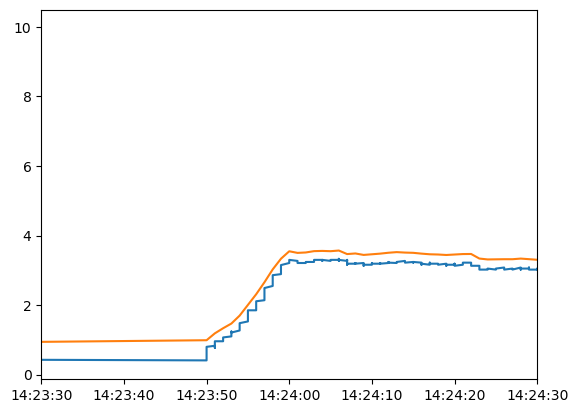

In [41]:
plt.plot(tag_ds_dives['PST_datetime'],tag_ds_dives['depth_m'])
plt.plot(interpolated_rbr_shift['time'],interpolated_rbr_shift['Sea_Pressure(dbar)'])
# plt.plot(interpolated_rbr['time'],interpolated_rbr['Sea_Pressure(dbar)'])
plt.xlim(pd.to_datetime('2020-11-02 14:23:30'), pd.to_datetime('2020-11-02 14:24:30'))

# FIT the response time 

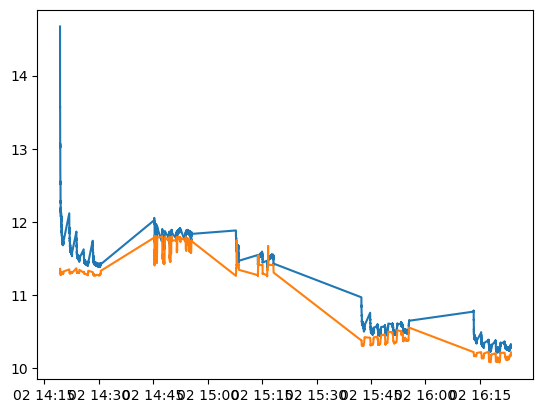

In [132]:
plt.plot(tag_ds_dives.PST_datetime,tag_ds_dives['ext_temperature_C']) 
plt.plot(interpolated_rbr_shift['time'],interpolated_rbr_shift['Temperature(°C)'])
# plt.plot(tag_ds_dives['ext_temperature_C'].values-interpolated_rbr_shift['Temperature(°C)'].values)

11.300346588990207
11.305700184729064
11.30930955314364
11.287656933508313
11.275819171442723


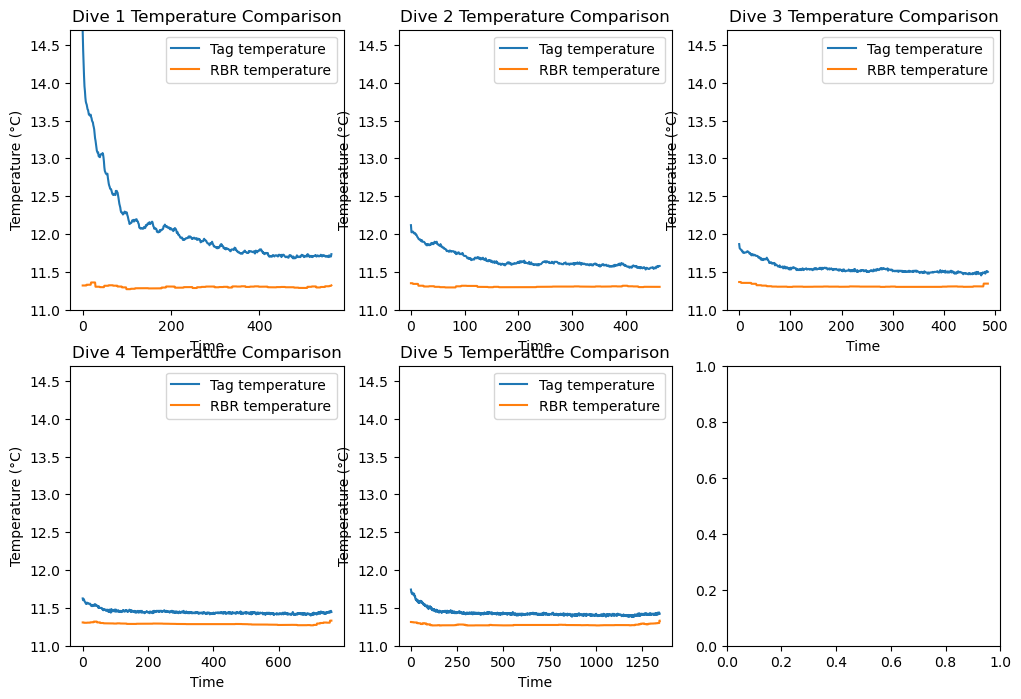

In [181]:
### dive =1
# idive=1
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for idive in range(1,6):

    interpolated_rbr_shift = interpolated_rbr_shift.assign(mask=('time', tag_ds_dives['mask'].values))

    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)
    # plt.plot(tag_dive.PST_datetime,tag_dive.ext_temperature_C)

    print(np.mean(rbr_dive_1['Temperature(°C)'].values))
    plt.subplot(2, 3, idive)
    # plt.figure(figsize=(4, 3))
    # rbr_dive_1['Temperature(°C)'].plot()
    plt.plot(tag_dive.ext_temperature_C.values, label="Tag temperature")
    plt.plot(rbr_dive_1['Temperature(°C)'], label="RBR temperature")
    plt.ylim(11,14.7)
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Dive {idive} Temperature Comparison')
    plt.legend()

    # plt.plot(tag_dive.ext_temperature_C.values-rbr_dive_1['Temperature(°C)'])
# rbr_dive_1['Sea_Pressure(dbar)'].plot()

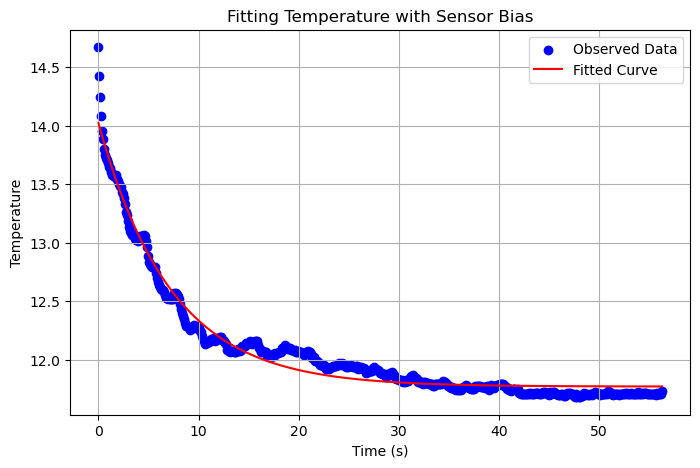

Estimated True Water Temperature: 12.42
Estimated Response Time (tau): 7.23 seconds
Estimated Bias (eta): -0.65


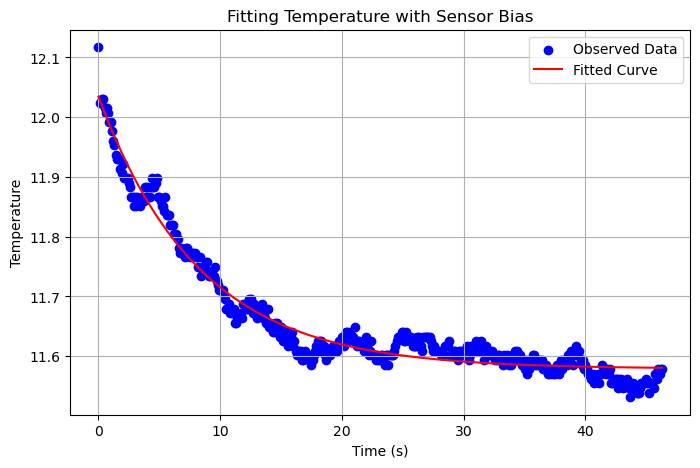

Estimated True Water Temperature: 11.66
Estimated Response Time (tau): 8.29 seconds
Estimated Bias (eta): -0.08


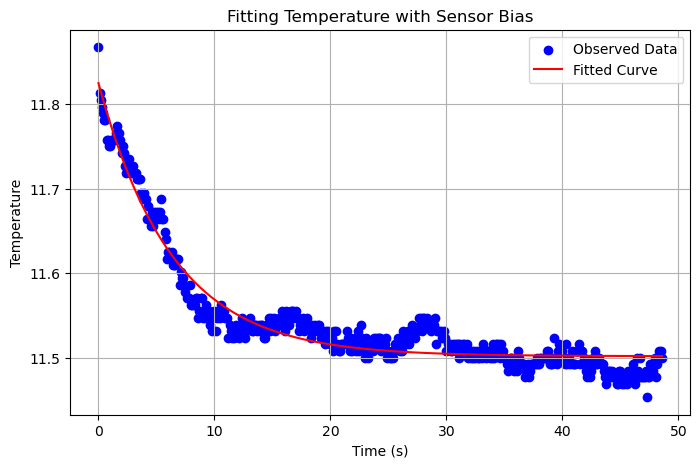

Estimated True Water Temperature: 11.54
Estimated Response Time (tau): 6.36 seconds
Estimated Bias (eta): -0.04


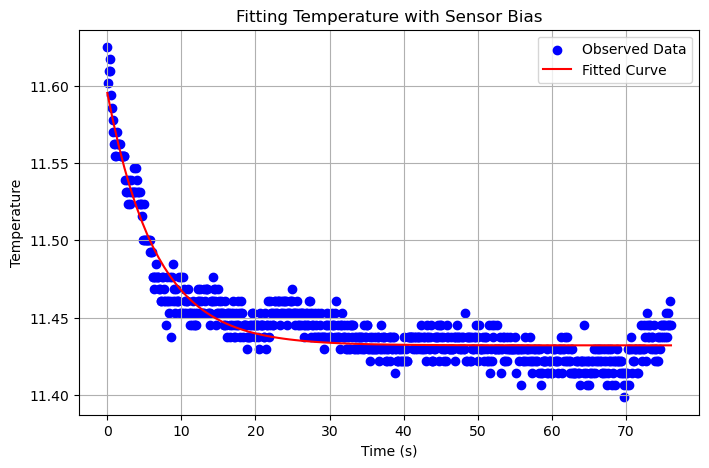

Estimated True Water Temperature: 11.46
Estimated Response Time (tau): 6.55 seconds
Estimated Bias (eta): -0.03


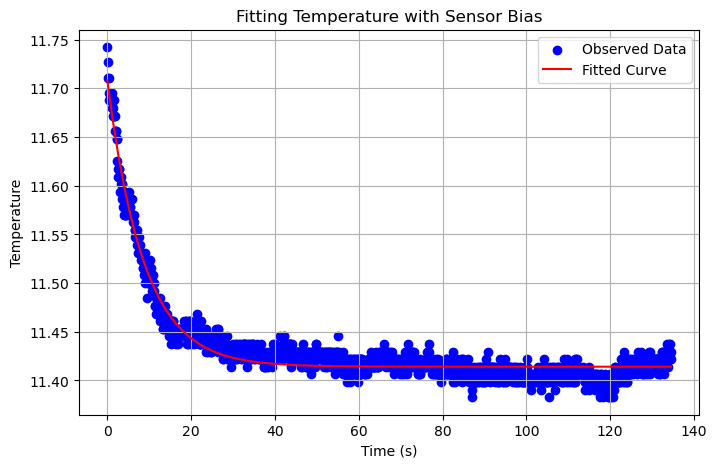

Estimated True Water Temperature: 11.45
Estimated Response Time (tau): 8.66 seconds
Estimated Bias (eta): -0.03


In [168]:
for idive in range(1,6):
    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)

    t_obs = np.arange(tag_dive.ext_temperature_C.size)*0.1

    T_obs =  tag_dive.ext_temperature_C.values # Observed temperatures
    T_true = rbr_dive_1['Temperature(°C)'].values  # True water temperature

    # Example dataset (replace with actual data)
    # t_obs = np.array([1, 2, 3, 4, 5])  # Time after immersion
    # T_obs = np.array([15.2, 18.3, 19.8, 20.4, 20.9])  # Observed temperatures
    T0 = T_obs[0]  # Initial temperature of sensor
    T_true_guess = 21.0  # Initial guess for true temperature
    eta_guess = 0.5  # Initial guess for bias

    # Define the nonlinear model including bias
    def temperature_model(t, T_true, tau, eta):
        return T_true + (T0 - T_true) * np.exp(-t / tau) + eta

    # Initial parameter guesses: (T_true, tau, eta)
    initial_guess = [T_true_guess, 5.0, eta_guess]

    # Fit the model
    popt, pcov = curve_fit(temperature_model, t_obs, T_obs, p0=initial_guess)

    # Extract fitted parameters
    T_true_fit, tau_fit, eta_fit = popt

    # Plot observed vs. fitted
    t_fit = np.linspace(0, max(t_obs), 100)
    T_fit = temperature_model(t_fit, *popt)

    plt.figure(figsize=(8, 5))
    plt.scatter(t_obs, T_obs, label="Observed Data", color="b")
    plt.plot(t_fit, T_fit, label="Fitted Curve", color="r")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature")
    plt.title("Fitting Temperature with Sensor Bias")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Estimated True Water Temperature: {T_true_fit:.2f}")
    print(f"Estimated Response Time (tau): {tau_fit:.2f} seconds")
    print(f"Estimated Bias (eta): {eta_fit:.2f}")


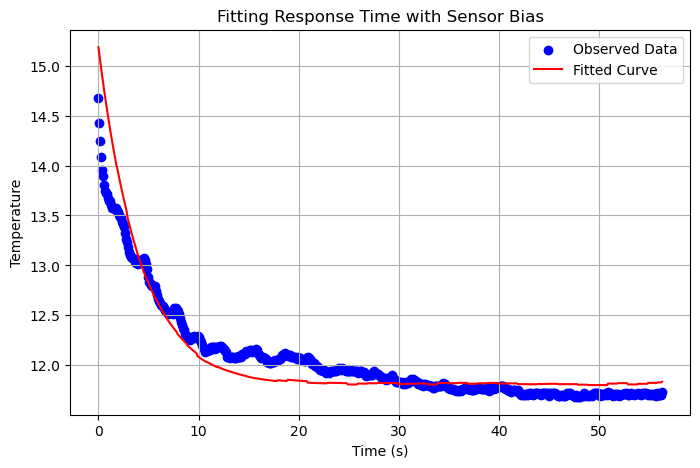

Estimated Response Time (tau): 4.11 seconds
Estimated Bias (eta): 0.51


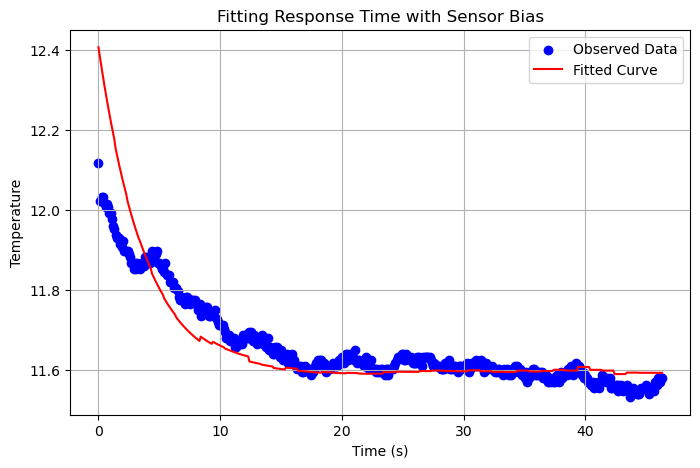

Estimated Response Time (tau): 3.70 seconds
Estimated Bias (eta): 0.29


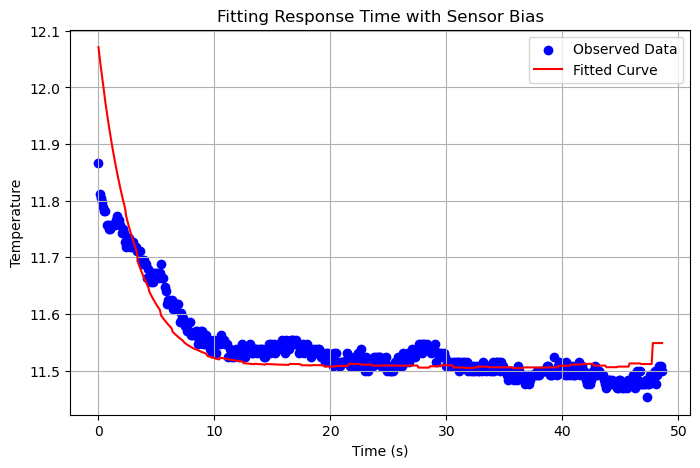

Estimated Response Time (tau): 2.84 seconds
Estimated Bias (eta): 0.20


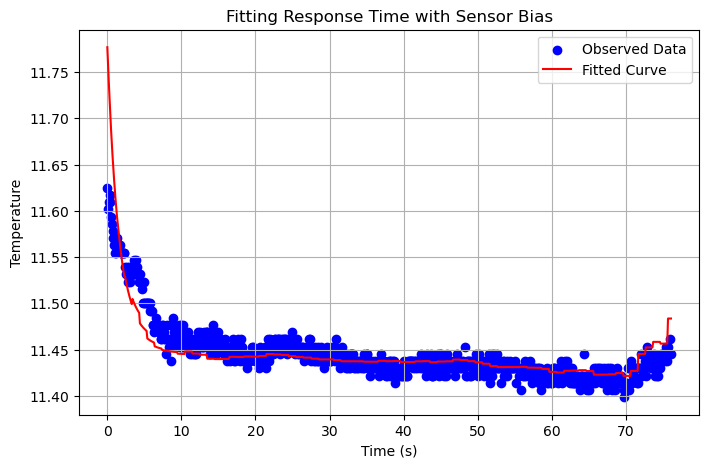

Estimated Response Time (tau): 1.55 seconds
Estimated Bias (eta): 0.15


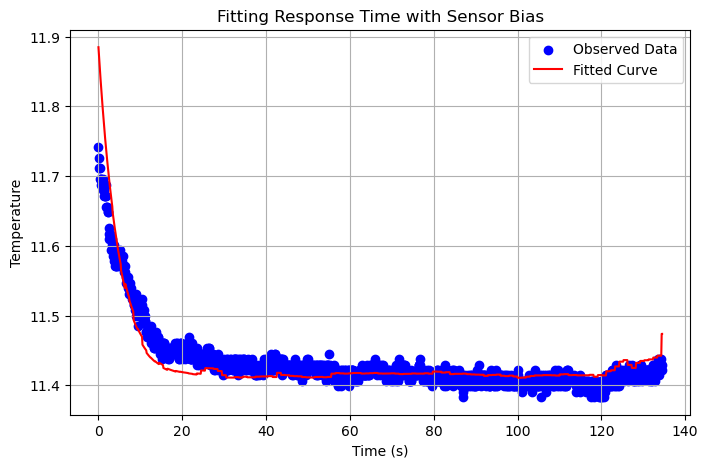

Estimated Response Time (tau): 4.44 seconds
Estimated Bias (eta): 0.14


In [189]:
for idive in range(1,6):
    tag_dive = tag_ds_dives.where(tag_ds_dives['mask'] == idive, drop=True)
    rbr_dive_1 = interpolated_rbr_shift.where(interpolated_rbr_shift['mask'] == idive, drop=True)

    t_obs = np.arange(tag_dive.ext_temperature_C.size)*0.1

    T_obs =  tag_dive.ext_temperature_C.values # Observed temperatures
    T_true = rbr_dive_1['Temperature(°C)'].values  # True water temperature

    # Example dataset (replace with actual data)
    # t_obs = np.array([1, 2, 3, 4, 5])  # Time after immersion (seconds)
    # T_obs = np.array([15.2, 18.3, 19.8, 20.4, 20.9])  # Observed temperatures
    # T_true = np.array([21.0, 21.0, 21.0, 21.0, 21.0])  # Known true temperatures
    T0 = T_obs[0]  # First recorded observed temperature

    # Define the fitting function
    def temperature_model(t, tau, eta):
        return T_true + (T0 - T_true) * np.exp(-t / tau) + eta

    # Initial guesses for tau and eta
    initial_guess = [5.0, 0.5]  # Guess tau=5s, eta=0.5

    # Fit the model
    popt, pcov = curve_fit(temperature_model, t_obs, T_obs, p0=initial_guess)

    # Extract fitted parameters
    tau_fit, eta_fit = popt

    # Generate fitted curve
    t_fit = t_obs
    T_fit = temperature_model(t_fit, *popt)

    # Plot observed vs. fitted
    plt.figure(figsize=(8, 5))
    plt.scatter(t_obs, T_obs, label="Observed Data", color="b")
    plt.plot(t_fit, T_fit, label="Fitted Curve", color="r")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature")
    plt.title("Fitting Response Time with Sensor Bias")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Estimated Response Time (tau): {tau_fit:.2f} seconds")
    print(f"Estimated Bias (eta): {eta_fit:.2f}")


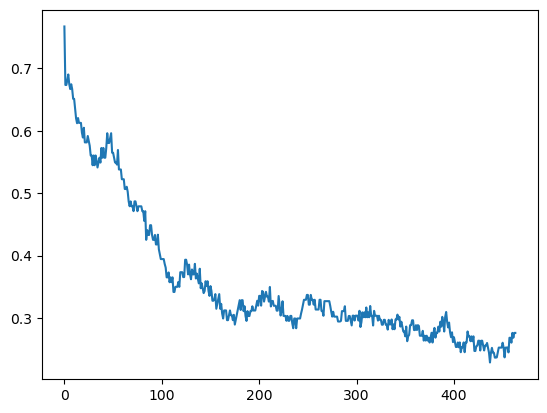

In [120]:
plt.plot(tag_dive.ext_temperature_C.values-rbr_dive_1['Temperature(°C)'].values)

In [97]:
np.unique(interpolated_rbr_shift['mask'])

array([ 0.,  1.,  2.,  3.,  4., 10., 11., 12., 13., 14., 15., 18., 19.,
       20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.])

In [50]:
interpolated_rbr_shift['Temperature(°C)'].values-tag_ds_dives['ext_temperature_C'].values

array([-3.35164286, -3.10945536, -2.92976786, ..., -0.11258929,
       -0.10477679, -0.10477679])

In [102]:
rbr_dive_1

<xarray.Dataset>
Dimensions:             (time: 510)
Coordinates:
  * time                (time) datetime64[ns] 2020-11-02T15:07:47 ... 2020-11...
    mask                (time) float64 15.0 15.0 15.0 15.0 ... 15.0 15.0 15.0
Data variables:
    Temperature(°C)     (time) float64 11.26 11.26 11.26 ... 11.34 11.34 11.34
    Pressure(dbar)      (time) float64 11.46 11.46 11.46 ... 10.94 10.94 10.94
    Sea_Pressure(dbar)  (time) float64 1.332 1.332 1.332 ... 0.8097 0.8097